In [1]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image

In [2]:
class FoveatedImageCompressor:
    def __init__(self, original_size=(256, 256), target_size=(96, 96)):
        self.original_size = original_size
        self.target_size = target_size

    def compress(self, pil_img):
        """
        Compress an image using foveated imaging techniques.
        This method now accepts and returns PIL Image.
        :param pil_img: A PIL Image representing the original image.
        :return: A PIL Image representing the compressed image.
        """
        # img_array = np.array(pil_img)  # Convert PIL Image to numpy array
        # Implement compression logic here
        compressed_image = pil_img.resize(self.target_size, Image.BILINEAR)


        # compressed_image = Image.fromarray(compressed_image_array)  # Convert back to PIL Image
        return compressed_image

    def decompress(self, pil_img):
        """
        Decompress an image back to its original size for visualization or processing.
        This method now accepts and returns PIL Image.
        :param pil_img: A PIL Image representing the compressed image.
        :return: A PIL Image representing the decompressed image.
        """
        img_array = np.array(pil_img)  # Convert PIL Image to numpy array
        # Implement decompression logic here
        decompressed_image_array = img_array  

        
        decompressed_image = Image.fromarray(decompressed_image_array)  # Convert back to PIL Image
        return decompressed_image

    def __call__(self, pil_img):
        # This allows the object to be used directly in PyTorch transforms
        return self.compress(pil_img)


In [7]:
# Instantiate your compressor once
foveated_compressor = FoveatedImageCompressor(original_size=(1024, 1024), target_size=(512, 512))

# Now the transform pipeline can be simplified
input_transforms = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: foveated_compressor(F.to_pil_image(x)))
])

target_transform = transforms.Compose([
    transforms.Resize((1024, 1024), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: foveated_compressor(F.to_pil_image(x)))
])

In [8]:
train_dataset = datasets.Cityscapes(
    root='data/cityscapes', 
    split='train', 
    mode='fine',
    target_type='semantic',
    transform=input_transforms,
    target_transform=target_transform
)

In [9]:
image, mask = next(iter(train_dataset))

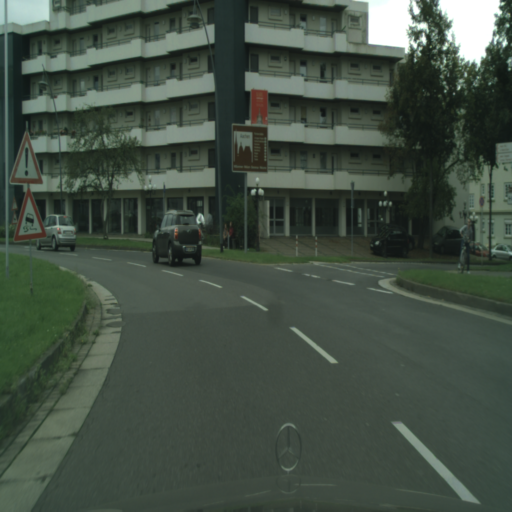

In [10]:
image

In [64]:
def gaussian_spatial_transform(image_size, focal_point=None, sigma=0.1):
    """
    Create a Gaussian spatial transformation map for an image.
    
    :param image_size: A tuple (height, width) of the image.
    :param focal_point: The center point for the Gaussian distribution, 
                        as a tuple (x, y). Defaults to the image center.
    :param sigma: The standard deviation of the Gaussian distribution.
    :return: A 2D tensor representing the transformation map.
    """
    height, width = image_size
    if focal_point is None:
        # Default to the center of the image
        focal_point = (width / 2, height / 2)
    
    # Create a grid of (x,y) coordinates
    y, x = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    
    # Calculate distances from the focal point
    dy = (y - focal_point[1]) / height
    dx = (x - focal_point[0]) / width
    distances = torch.sqrt(dx**2 + dy**2)

    # Create the Gaussian distribution
    gaussian_map = torch.exp(-0.5 * (distances / sigma)**2)

    # Normalize the map to have values between 0 and 1
    gaussian_map = gaussian_map / torch.max(gaussian_map)

    # Stack the map to create a 2-channel transformation map
    transformation_map = torch.stack([gaussian_map, gaussian_map], dim=0)

    

    return transformation_map

# Example usage:
image_tensor = transforms.ToTensor()(image)
# Assuming you have a tensor 'image_tensor' of shape [C, H, W]
transform_map = gaussian_spatial_transform((image_tensor.size(1), image_tensor.size(2)))
# Apply the spatial transform using grid_sample from PyTorch
# Note: image_tensor.unsqueeze(0) adds a batch dimension, which is required for grid_sample
transformed_image = torch.nn.functional.grid_sample(image_tensor.unsqueeze(0), transform_map.unsqueeze(0), mode='bilinear', padding_mode='border', align_corners=True).squeeze(0)
# Convert the tensor back to a PIL image for visualization
transformed_image_pil = transforms.ToPILImage()(transformed_image)
transformed_image_pil

RuntimeError: grid_sampler(): expected grid to have size 2 in last dimension, but got grid with sizes [1, 2, 512, 512]